In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import pearsonr
import matplotlib

In [2]:
save_dir = "results/gpt2_vs_bert"
os.makedirs(save_dir, exist_ok=True)

In [3]:
def assign_significance(pval):
    if pval < 0.001:
        sig = "***"
    elif pval < 0.01:
        sig = "**"
    elif pval < 0.05:
        sig = "*"
    else:
        sig = "n.s."
    return sig

In [4]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'ytick.left': True,
                 'xtick.bottom': True,
                'grid.linestyle': "" #gets rid of horizontal lines
                }
sns.set_theme(font_scale=1.4, style="white", rc=custom_params)
#plt.style.use('seaborn-dark-palette')

In [5]:
def correlate_gpt_with_bert(GPT_VERSION, BERT_VERSION, DATASET, MASKING):
    # Read GPT scores
    df_gpt = pd.read_csv(f'results/{DATASET}/{GPT_VERSION}/{DATASET}.csv')
    df_gpt = df_gpt.rename(columns={
        "PLL score" : "GPT2 LL score"
    })
    
    # Read BERT scores
    df_bert = pd.read_csv(f'results/{DATASET}/{BERT_VERSION}/{DATASET}_{MASKING}.csv')
    df_bert = df_bert.rename(columns={
        "PLL score" : "BERT PLL score"
    })
    
    # Merge dataframes
    if DATASET == "EventsAdapt":
        plot_df = df_gpt.merge(df_bert, how="inner", on="sentence")
    elif DATASET == "LibriSpeech":
        plot_df = df_gpt.merge(df_bert, how="inner", on="ref sentence")
    else:
        raise NotImplementedError
    
    #sns.set_palette([sns.cubehelix_palette(5)[3]])
    r, pval = pearsonr(plot_df["GPT2 LL score"], plot_df["BERT PLL score"])
    sns.regplot(data=plot_df, x="GPT2 LL score", y="BERT PLL score").set(title=f'{DATASET} | {GPT_VERSION} vs. {BERT_VERSION} | {MASKING}\nR={round(r,2)} {assign_significance(pval)}')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/{DATASET}_{GPT_VERSION}_vs_{BERT_VERSION}{MASKING}.png", dpi=300, bbox_inches='tight')
    plt.show()

# EventsAdapt

In [6]:
# correlate_gpt_with_bert("gpt2-medium", "bert-base-cased", "EventsAdapt", "OriginalPLL")

In [7]:
# correlate_gpt_with_bert("gpt2-medium", "bert-base-cased", "EventsAdapt", "AdjustedPLL_l2r")

In [8]:
# correlate_gpt_with_bert("gpt2-medium", "bert-base-cased", "EventsAdapt", "AdjustedPLL_mlm")

# LibriSpeech

In [9]:
# correlate_gpt_with_bert("gpt2-medium", "bert-base-cased", "LibriSpeech", "OriginalPLL")

In [10]:
# correlate_gpt_with_bert("gpt2-medium", "bert-base-cased", "LibriSpeech", "AdjustedPLL_l2r")

In [11]:
# correlate_gpt_with_bert("gpt2-medium", "bert-base-cased", "LibriSpeech", "AdjustedPLL_mlm")

# Subplots for each dataset

In [12]:
RENAME_DICT_MODELS = {
    "gpt2-medium" : "GPT2-medium",
    "gpt2-xl" : "GPT2-xl",
    "bert-base-cased" : "BERT (base)",
    "bert-large-cased" : "BERT (large)",
    "roberta-base" : "RoBERTa (base)"
}

RENAME_DICT_METRICS = {
    "OriginalPLL" : "PLL-original",
    "AdjustedPLL_l2r" : "PLL-word-l2r",
    "AdjustedPLL_mlm" : "PLL-whole-word",
    "" : ""
}

def rename(x):
    if x in RENAME_DICT_MODELS:
        return RENAME_DICT_MODELS[x]
    else:
        return RENAME_DICT_METRICS[x]

In [13]:
def correlate_gpt_with_bert_subplots(GPT_VERSION, BERT_VERSION, DATASET):
    # Read GPT scores
    df_gpt = pd.read_csv(f'results/{DATASET}/{GPT_VERSION}/{DATASET}.csv')
    df_gpt = df_gpt.rename(columns={
        "PLL score" : f"{rename(GPT_VERSION)} LL score"
    })
    
    fig, axes = plt.subplots(ncols=3, sharey=False, figsize=(15, 5))
    #fig.suptitle(f"{DATASET} | {rename(GPT_VERSION)} vs. {rename(BERT_VERSION)}", fontweight="bold", fontstyle='italic')
    # Read BERT scores
    for ind, MASKING in enumerate(["OriginalPLL", "AdjustedPLL_l2r", "AdjustedPLL_mlm"]):
        df_bert = pd.read_csv(f'results/{DATASET}/{BERT_VERSION}/{DATASET}_{MASKING}.csv')
        df_bert = df_bert.rename(columns={
            "PLL score" : f"{rename(BERT_VERSION)} PLL score"
        })
    
        # Merge dataframes
        if DATASET in ["EventsAdapt", "Brown"]:
            plot_df = df_gpt.merge(df_bert, how="inner", on="sentence")
        elif DATASET == "LibriSpeech":
            plot_df = df_gpt.merge(df_bert, how="inner", on="ref sentence")
        else:
            raise NotImplementedError

        r, pval = pearsonr(plot_df[f"{rename(GPT_VERSION)} LL score"], plot_df[f"{rename(BERT_VERSION)} PLL score"])
        
        # call regplot on each axes
        #sns.set_palette([sns.cubehelix_palette(5)[2]])
        palette = sns.cubehelix_palette(rot=-.2)[::-1]
        sns.regplot(data=plot_df, x=f"{rename(GPT_VERSION)} LL score", y=f"{rename(BERT_VERSION)} PLL score",
                    ax=axes[ind], scatter_kws={"color": palette[2], "edgecolor": 'w',
                                              "linewidth":0.5,
                                              "s":50},
                    line_kws={"color": palette[1]}
                   ).set_title(f'{rename(MASKING)}\nR={round(r,2)} {assign_significance(pval)}',
                        fontdict={"fontweight":"bold", "fontsize":18}, pad=7)
        axes[ind].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
        axes[ind].tick_params(axis='both', which='minor', length=10, width=2, labelsize=14)
        
    plt.tight_layout()
    plt.savefig(f"{save_dir}/{DATASET}_{BERT_VERSION}_subplots.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_dir}/{DATASET}_{BERT_VERSION}_subplots.pdf", dpi=300, bbox_inches='tight')
    plt.show()

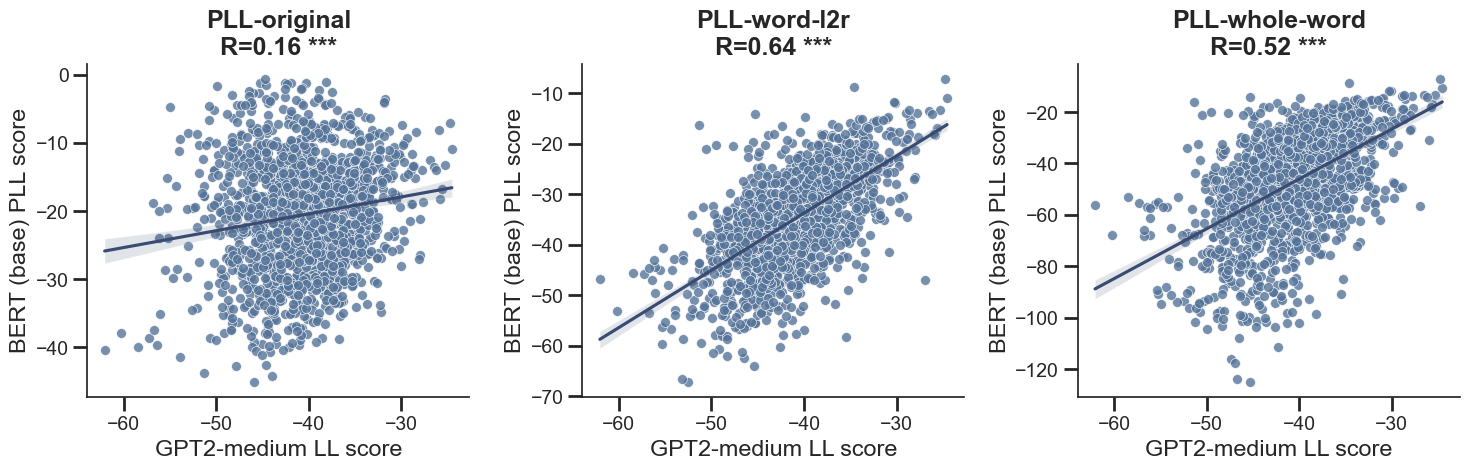

In [14]:
correlate_gpt_with_bert_subplots(GPT_VERSION="gpt2-medium", BERT_VERSION="bert-base-cased", DATASET="EventsAdapt")

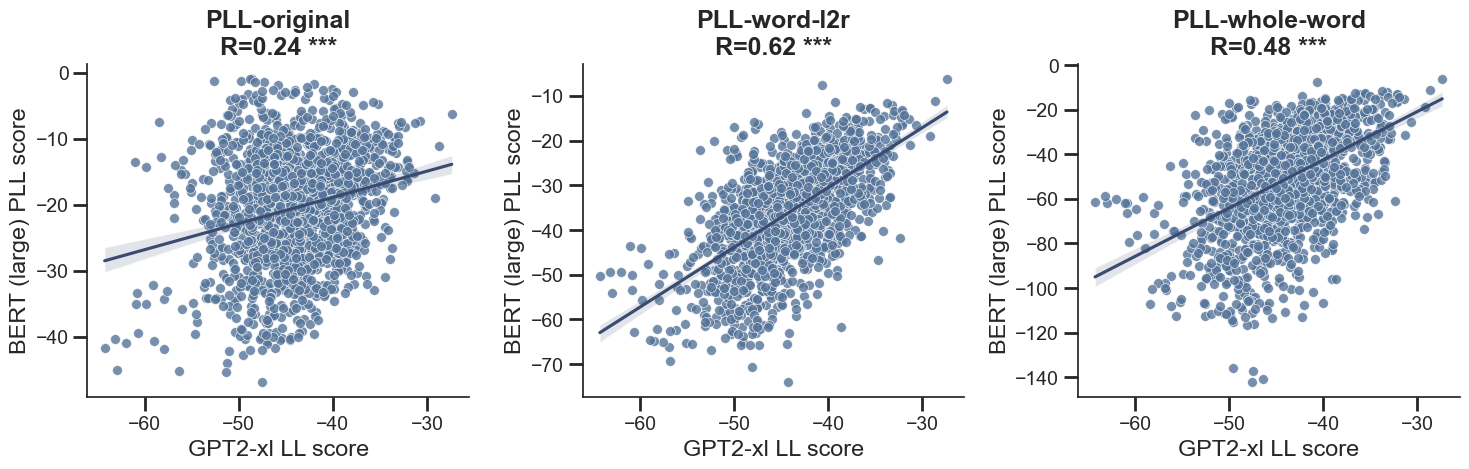

In [15]:
correlate_gpt_with_bert_subplots(GPT_VERSION="gpt2-xl", BERT_VERSION="bert-large-cased", DATASET="EventsAdapt")

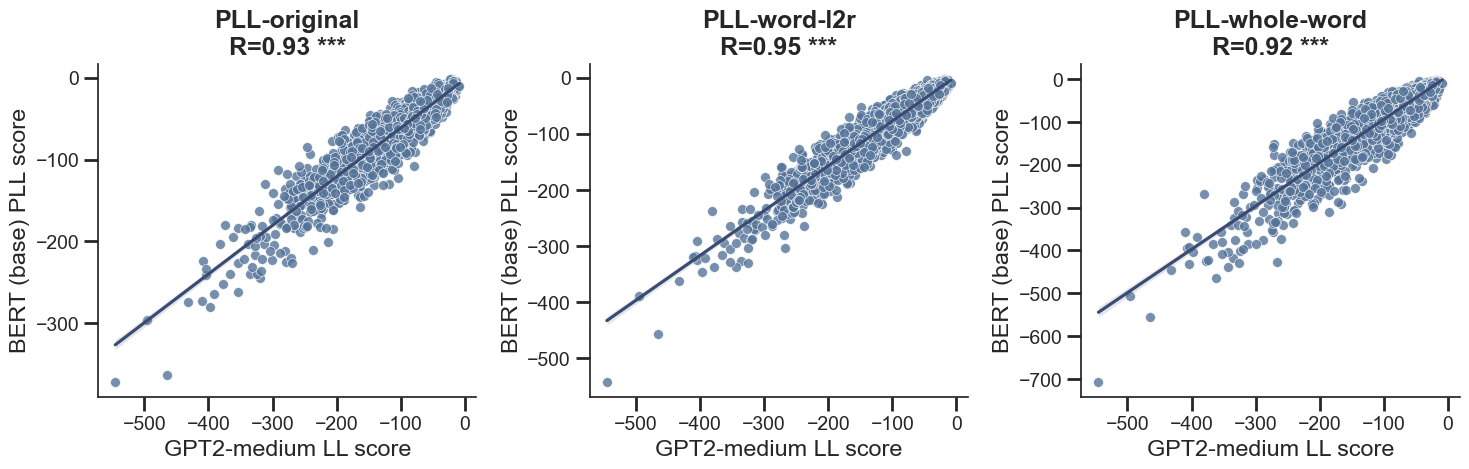

In [16]:
correlate_gpt_with_bert_subplots(GPT_VERSION="gpt2-medium", BERT_VERSION="bert-base-cased", DATASET="LibriSpeech")

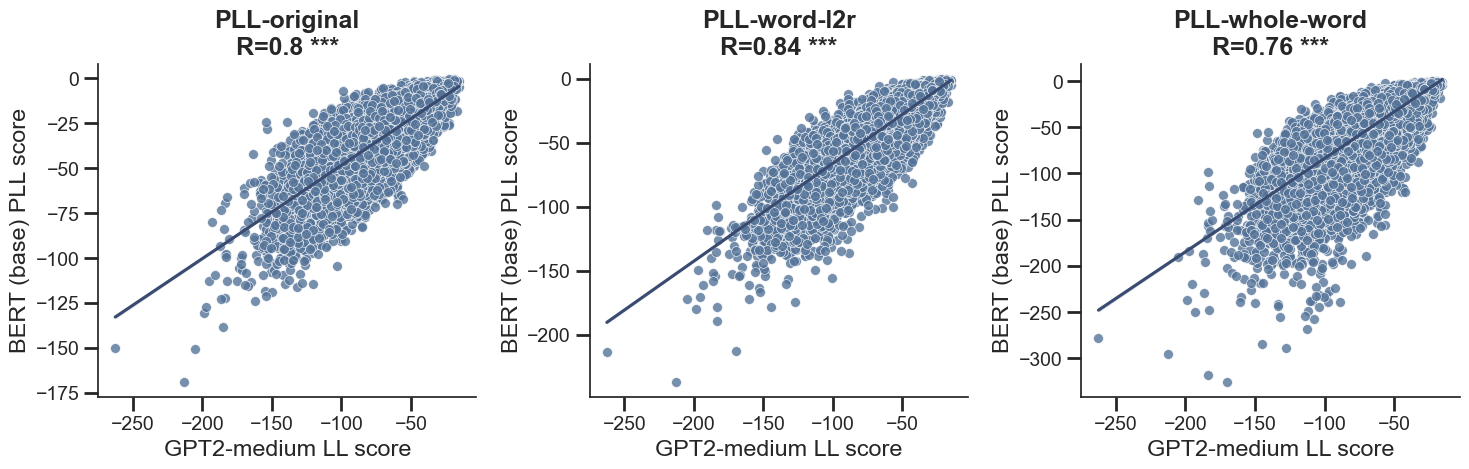

In [17]:
correlate_gpt_with_bert_subplots(GPT_VERSION="gpt2-medium", BERT_VERSION="bert-base-cased", DATASET="Brown")

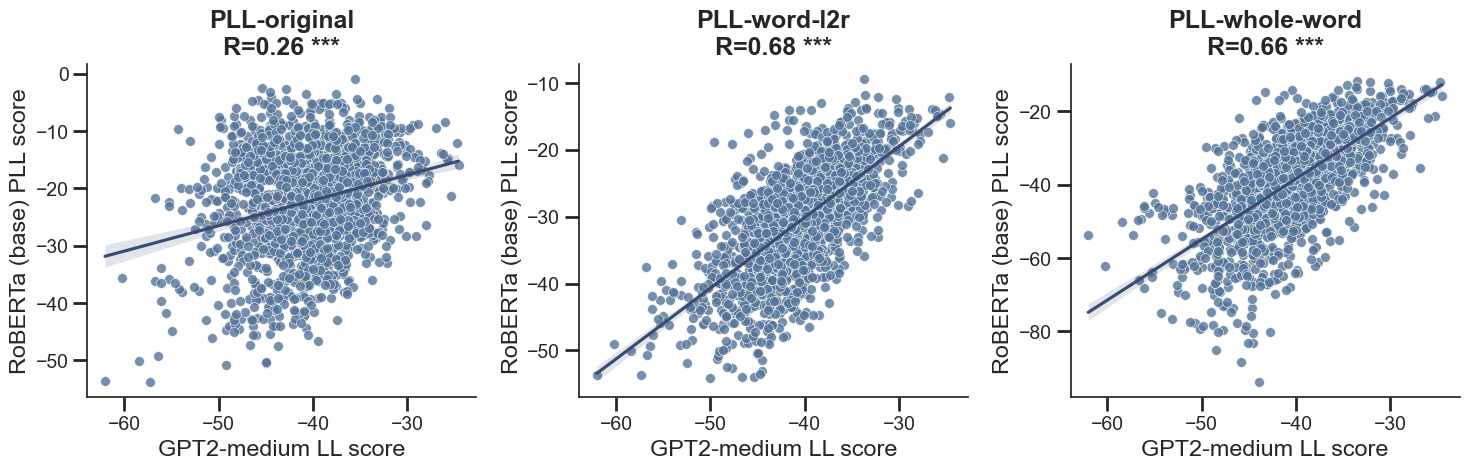

In [18]:
correlate_gpt_with_bert_subplots(GPT_VERSION="gpt2-medium", BERT_VERSION="roberta-base", DATASET="EventsAdapt")

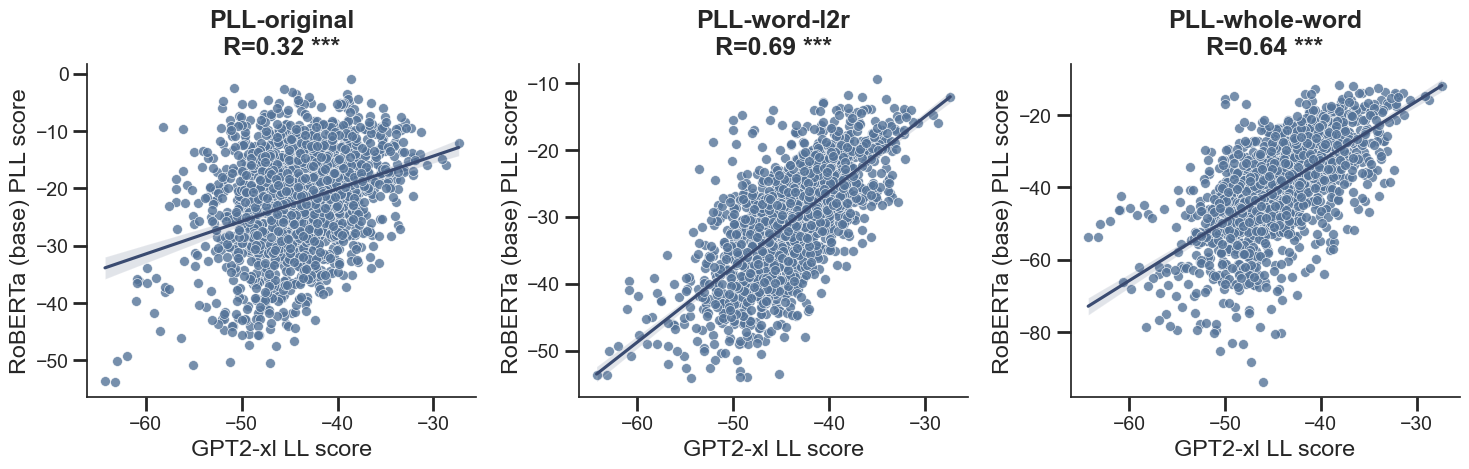

In [19]:
correlate_gpt_with_bert_subplots(GPT_VERSION="gpt2-xl", BERT_VERSION="roberta-base", DATASET="EventsAdapt")